In [1]:
import vrep
import numpy
import time
import sys

%matplotlib notebook
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}

plt.rc('font', **font)


In [2]:
#
# Controls if the results are saved to a file
#

# added_cm = "_AJUSTABLE_0.0" # VREP Z TABLE POSITION: +7.6340e-01
# added_cm = "_AJUSTABLE_0.25cm" # VREP Z TABLE POSITION: +7.6590e-01
# added_cm = "_AJUSTABLE_0.5cm" # VREP Z TABLE POSITION: +7.6340e-01
# added_cm = "_AJUSTABLE_0.75cm" # VREP Z TABLE POSITION: +7.7090e-01
# added_cm = "_AJUSTABLE_1.0cm" # VREP Z TABLE POSITION: +7.7340e-01
# added_cm = "_AJUSTABLE_1.25cm" # VREP Z TABLE POSITION: +7.7590e-01


save2file = True

headless = False

In [51]:
# Location of the V-REP simulator main file:
vrep_location = "/software/V-REP/vrep.sh"

In [52]:
# Generates the movements according to:
# Flash, Tamar and Neville Hogan. 1985. The Coordination of Arm Movements: An Experimentally Confirmed 
# Mathematical Model. The Journal of Neuroscience 5 (7): 1688-1703
def movement_generation_training(xstart,xdest,MT,t):
    '''
    xstart,ystart: initial position of the trajectory
    MT: total time spent doing the trajectory
    t: current time
    
    returns a matrix: [[x0,y0],[x1,y1],...]
    '''
    x_t=xstart+(xstart-xdest)*(15*(t/MT)**4-6*(t/MT)**5-10*(t/MT)**3)
    return numpy.array(x_t)

In [2]:
sim_set = "square" # basically is the name of the folder where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

In [54]:
MT=0.5 # The SQUARE is made of four straight lines (0.5s x 4 = 2s)
time_step=2E-3
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [55]:
x = -0.5
y = -0.5

# Square
trajectories = [[[x,y],[1.0+x,y]],\
                [[1.0+x,y],[1.0+x,1.0+y]],\
                [[1.0+x,1.0+y],[x,1.0+y]],\
                [[x,1.0+y],[x,y]]]

orig_trajectories = numpy.array(trajectories)

trajectories = numpy.array(trajectories)

In [56]:
# Creates an empty matrix to store the points
XY_movement = numpy.zeros((0,2))

for tji in range(4):

    xstart=trajectories[tji][0][0]
    ystart=trajectories[tji][0][1]
    xdest=trajectories[tji][1][0]
    ydest=trajectories[tji][1][1]

    x_movement = movement_generation_training(xstart,xdest,MT,t_mov)
    y_movement = movement_generation_training(ystart,ydest,MT,t_mov)
    
    XY_movement_temp = numpy.zeros((len(t_mov),2))

    XY_movement_temp[:,0]=x_movement
    XY_movement_temp[:,1]=y_movement

    # Concatenates all the lines to make a square
    XY_movement=numpy.concatenate((XY_movement,numpy.round(XY_movement_temp/6.0,4)))

<IPython.core.display.Javascript object>


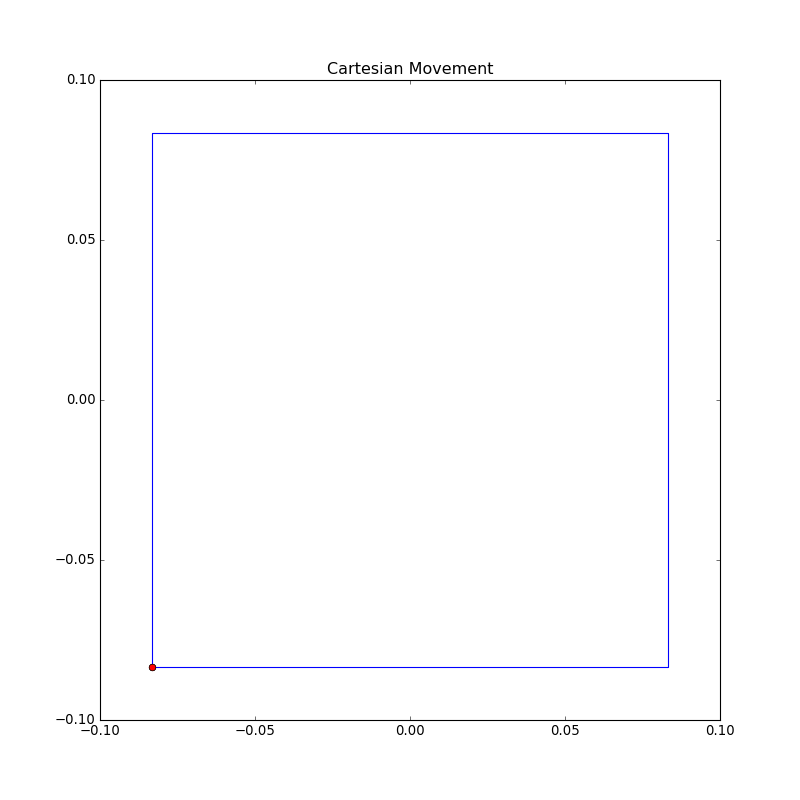

In [57]:
tji_orig = 0
plt.figure(figsize =(10,10))
plt.plot(XY_movement[:,0],XY_movement[:,1])
plt.plot([XY_movement[0,0]],[XY_movement[0,1]],'go')
plt.plot([XY_movement[-1,0]],[XY_movement[-1,1]],'ro')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.title("Cartesian Movement")
plt.show()

In [58]:
#
# Saves the original values to a file
# 

if save2file:
    numpy.save(base_dir+"/"+sim_set+"/"+sim_set+"_shape_points.npy",XY_movement)

In [77]:
import os


p = None
if (headless):
    # To automate the process is necessary to avoid the firewall message by deactivating it!!!!
    p = subprocess.Popen([vrep_location, '-h', '-s', '-q', \
                          os.getcwd()+'/VREP_scenes/Baxter_IK_felt_pen_TallerTable(2xIK).ttt'])  

time.sleep(1.0)

# Object names (used inside the simulation)
# They are used to retrieve the object handles
s0_name = 'Baxter_leftArm_joint1'
s1_name = 'Baxter_leftArm_joint2'
e0_name = 'Baxter_leftArm_joint3'
e1_name = 'Baxter_leftArm_joint4'
w0_name = 'Baxter_leftArm_joint5'
w1_name = 'Baxter_leftArm_joint6'
w2_name = 'Baxter_leftArm_joint7'
XY_pos = 'IK_XY_MASTER' # Controls the cartesian X,Y values (pen)
Z_pos = 'IK_Z_MASTER' # Controls the cartesian Z value (pen)


# simxPauseCommunication(clientID,1);
# simxSetJointPosition(clientID,joint1Handle,joint1Value,simx_opmode_oneshot);
# simxSetJointPosition(clientID,joint2Handle,joint2Value,simx_opmode_oneshot);
# simxSetJointPosition(clientID,joint3Handle,joint3Value,simx_opmode_oneshot);
# simxPauseCommunication(clientID,0);
# Above's 3 joints will be received and set on the V-REP side at the same time

print 'Program started'
vrep.simxFinish(-1) # just in case, close all opened connections

# Connects to the simulator
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5)

if clientID!=-1:
    print 'Connected to remote API server'
    res,objs=vrep.simxGetObjects(clientID,vrep.sim_handle_all,vrep.simx_opmode_oneshot_wait) # gets ALL object handles
    if res==vrep.simx_return_ok:
        print 'Number of objects in the scene: ',len(objs)
        res0,XY=vrep.simxGetObjectHandle(clientID,XY_pos,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the IK_XY_MASTER
        res1,Z=vrep.simxGetObjectHandle(clientID,Z_pos,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the IK_Z_MASTER
        
        res2,s0=vrep.simxGetObjectHandle(clientID,s0_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the s0 joint
        res3,s1=vrep.simxGetObjectHandle(clientID,s1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the s1 joint
#         resX,e0=vrep.simxGetObjectHandle(clientID,e0_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the e0 joint
        res4,e1=vrep.simxGetObjectHandle(clientID,e1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the e1 joint
#         resX,w0=vrep.simxGetObjectHandle(clientID,w0_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the w0 joint
        res5,w1=vrep.simxGetObjectHandle(clientID,w1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the w1 joint
#         resX,w2=vrep.simxGetObjectHandle(clientID,w2_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the w2 joint

        print res0,res1,res2,res3,res4,res5

        if (res0+res1+res2+res3+res4+res5)==vrep.simx_return_ok:
            print "Ok, I'm in!"
            
            joint_list = [s0,s1,e1,w1]
            joint_positions = []
            
            #
            # These are the equivalent to X,Y,Z = 0,0,0 in my system:
            #
            
            # Reads the current XY_Master position [X,Y]
            print "Reads the current XY_Master position [X,Y]"
            res,posXY=vrep.simxGetObjectPosition(clientID,XY,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            # Reads the current Z_Master position [Z]
            print "Reads the current Z_Master position [Z]"
            res,posZ=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)
            
            print "Initial XY Master Position", posXY
            print "Initial Z Master Position", posZ

            
            # Lifts the pen to position it in the trajectory's starting point
            # This is acomplished by increasing the Z value (posZ[2])
            print "Lifts the pen to position it in the trajectory's starting point"
            # I need a smooth movements, otherwise the pen touches the table by mistake.
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZ[0], posZ[1], posZ[2]+0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)
                        
            # Moves to the first position
            # This movement is relative to the current XY position!!!
            print "Moves to the first position"
            res = vrep.simxSetObjectPosition(clientID,XY,vrep.sim_handle_parent,[posXY[0]+XY_movement[0,0],\
                                                                                 posXY[1]+XY_movement[0,1], posXY[2]],vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            
            # Puts down the pen
            print "Puts down the pen"
            # I need smooth movements, otherwise the pen touches the table by mistake.
            # Reads the current Z_Master position [Z]
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZcurrent[0], posZcurrent[1], posZcurrent[2]-0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)            
            
            if res!=0:
                vrep.simxFinish(clientID)
                print 'Remote API function call returned with error code (start-up): ',res
          
            # Reads the current XY_Master position [X,Y]
            print "Reads the current XY_Master position [X,Y]"
            res,posXYcurrent=vrep.simxGetObjectPosition(clientID,XY,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            # Reads the current Z_Master position [Z]
            print "Reads the current Z_Master position [Z]"
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)            

            print "XY Master Position:", posXYcurrent
            print "Z Master Position:", posZcurrent
        
        
            i = 0
            for hi in XY_movement:
                # Reads and saves the current joint positions
                temp = []
                for ji in joint_list:
                    res,joint_pos=vrep.simxGetJointPosition(clientID,ji,vrep.simx_opmode_oneshot_wait)
                    temp.append(joint_pos)
                joint_positions.append(temp)
                
                
                
                if i==0:
                    if save2file:
                        numpy.save(base_dir+"/"+sim_set+"/starting_joint_pos.npy",numpy.array(temp))                

                cmd_pos = numpy.array(posXY)+numpy.concatenate([hi,[0]]) # Sums X and Y in the pos and [hi[0],hi[1],0] arrays

                i+=1
                # Sets the new position
                res = vrep.simxSetObjectPosition(clientID,XY,vrep.sim_handle_parent,cmd_pos,vrep.simx_opmode_oneshot_wait)
                #time.sleep(0.0025) # 0.05 here was generating too many time-out errors!                
                
                if res!=0:
                    vrep.simxFinish(clientID)
                    print 'Remote API function call returned with error code (main loop): ',res
                    break

            # Lifts the pen to position it in the trajectory's starting point
            # I need a smooth movements, otherwise the pen touches the table by mistake.
            # Reads the current Z_Master position [Z]
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)            
        
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZcurrent[0], posZcurrent[1], posZcurrent[2]+0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)            

            
            # Moves it back to the first position
            res = vrep.simxSetObjectPosition(clientID,XY,vrep.sim_handle_parent,posXY,vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            # Puts down the pen
            # I need a smooth movements, otherwise the pen touches the table by mistake.
            # Reads the current Z_Master position [Z]
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZcurrent[0], posZcurrent[1], posZcurrent[2]-0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)      
                
            if res!=0:
                vrep.simxFinish(clientID)
                print 'Remote API function call returned with error code (last position): ',res
                
        else:
            print 'Remote API function call returned with error code (object handles): ',res
    else:
        print 'Remote API function call returned with error code (first connection): ',res
#     returncode=vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot_wait)
    vrep.simxFinish(clientID)
else:
    print 'Failed connecting to remote API server'
print 'Program ended'
if p:
    # Terminates the process, in the case the connection above failed.
    p.terminate()

Program started
Connected to remote API server
Number of objects in the scene:  95
0 0 0 0 0 0
Ok, I'm in!
Reads the current XY_Master position [X,Y]
Reads the current Z_Master position [Z]
Initial XY Master Position [-0.25862473249435425, 0.39768704771995544, 1.1146631240844727]
Initial Z Master Position [0.08606263995170593, -0.008990883827209473, 0.006720542907714844]
Lifts the pen to position it in the trajectory's starting point
Moves to the first position
Puts down the pen
Reads the current XY_Master position [X,Y]
Reads the current Z_Master position [Z]
XY Master Position: [-0.3419247269630432, 0.3143870532512665, 1.1146631240844727]
Z Master Position: [0.08606252074241638, -0.008990764617919922, 0.006720542907714844]
Program ended


(1000, 4)


<IPython.core.display.Javascript object>


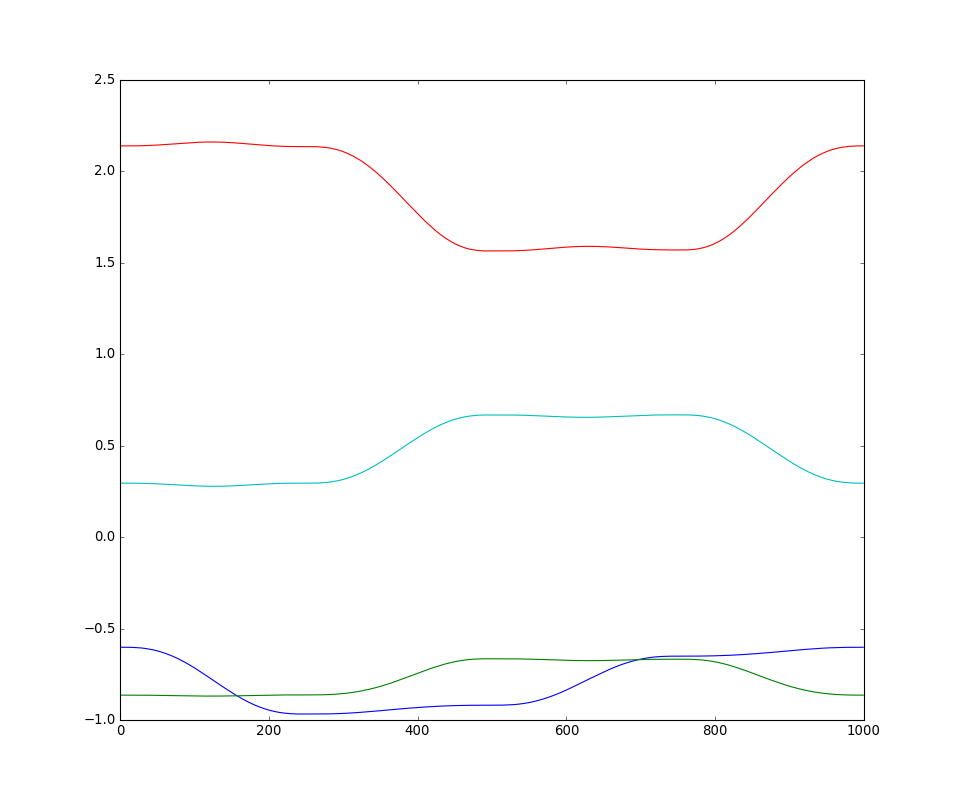

In [79]:
joint_positions = numpy.array(joint_positions)
print joint_positions.shape

#acc_values = numpy.array(acc_values)
#print acc_values.shape

#saves points to a file
if save2file:
    numpy.save(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+added_cm+".npy",joint_positions)
    

xy = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+added_cm+".npy")

fig=plt.figure(figsize =(12,10))
plt.plot(xy)
plt.show()

<IPython.core.display.Javascript object>


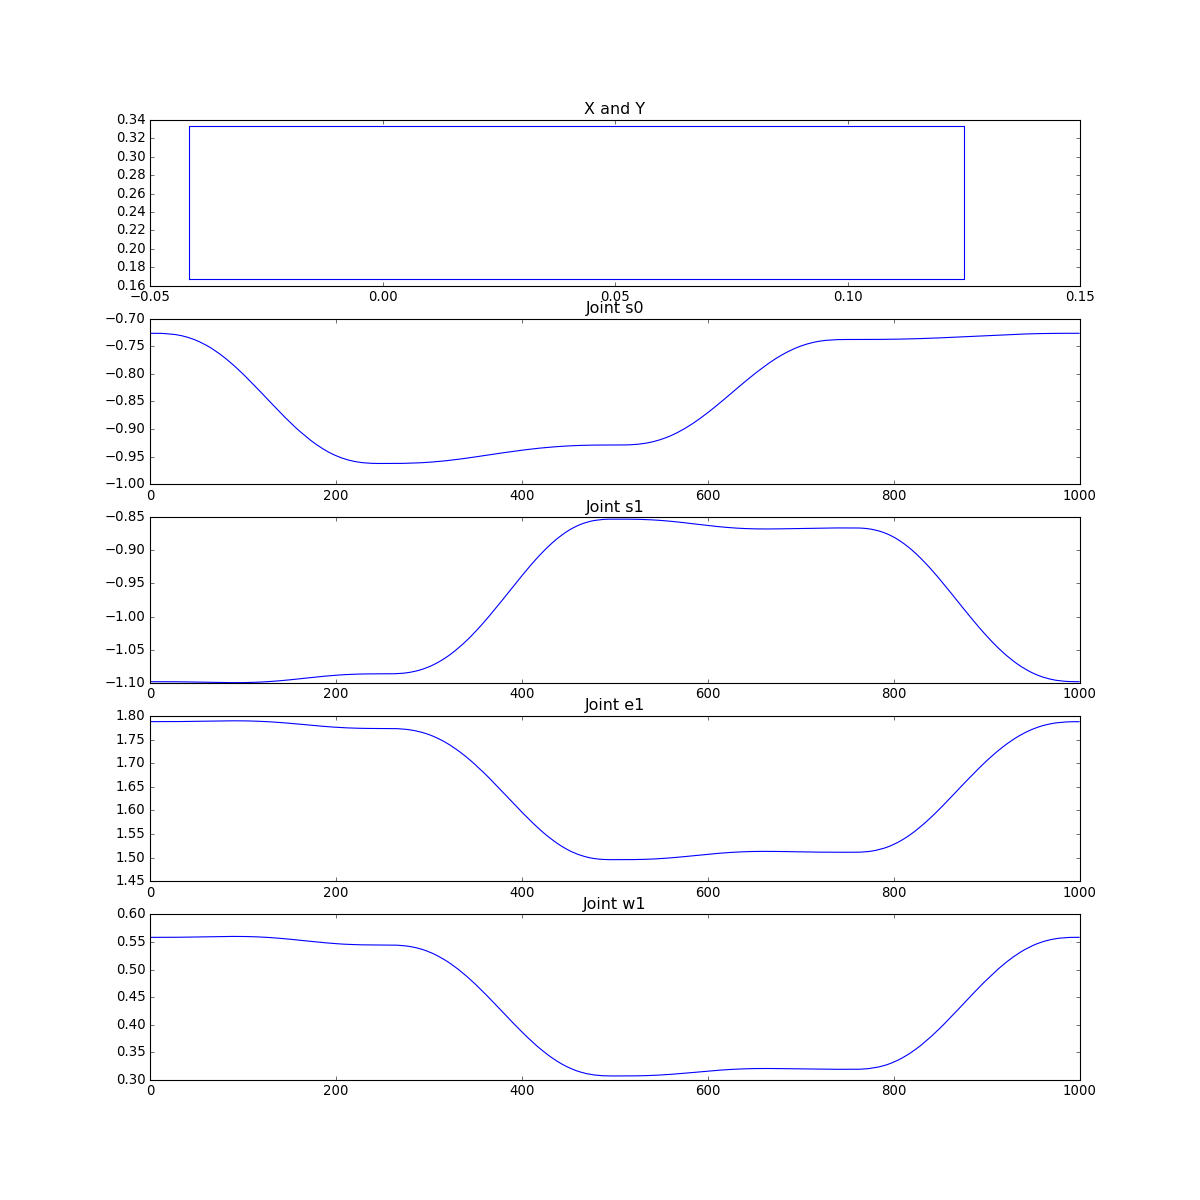

In [22]:


fig=plt.figure(figsize =(15,15));

plt.subplot(5,1,1)
plt.plot(XY_movement[:,0],XY_movement[:,1])
plt.title("X and Y")

plt.subplot(5,1,2)
plt.plot(joint_positions[:,0])
plt.xlim(0,len(joint_positions))
plt.title("Joint s0")

plt.subplot(5,1,3)
plt.plot(joint_positions[:,1])
plt.xlim(0,len(joint_positions))
plt.title("Joint s1")

plt.subplot(5,1,4)
plt.plot(joint_positions[:,2])
plt.xlim(0,len(joint_positions))
plt.title("Joint e1")

plt.subplot(5,1,5)
plt.plot(joint_positions[:,3])
plt.xlim(0,len(joint_positions))
plt.title("Joint w1")

plt.show()

<IPython.core.display.Javascript object>


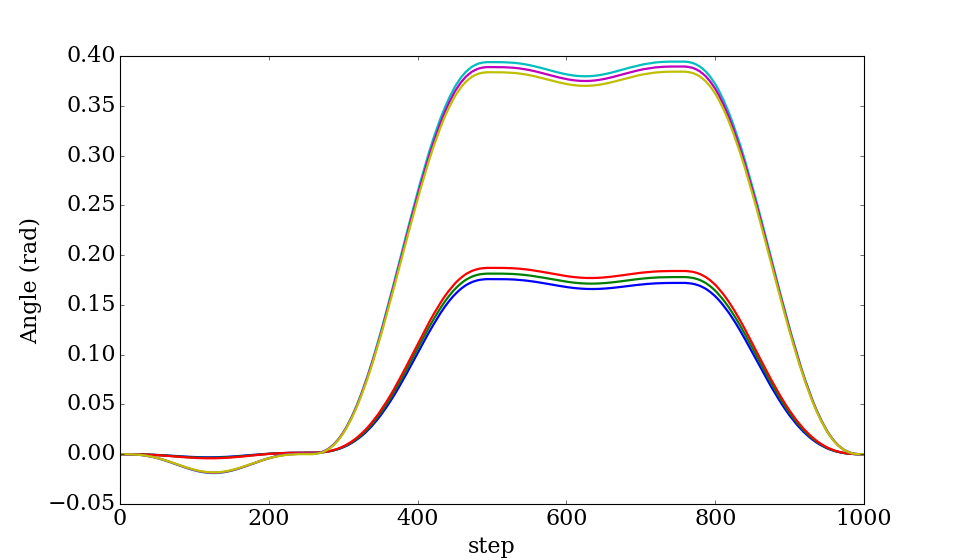

In [4]:


xy1 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_+0.0cm.npy")
xy2 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_+0.5cm.npy")
xy3 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_+1.0cm.npy")

xy4 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_+1.5cm.npy")

xy5 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_+2.0cm.npy")
# xy4 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_AJUSTABLE_0.75cm.npy")
# xy5 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_AJUSTABLE_1.0cm.npy")
# xy6 = numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+"_AJUSTABLE_1.25cm.npy")

fig=plt.figure(figsize =(12,7))    
for i in (1,3):
    plt.plot(xy1[:,i]-xy1[0,i],linewidth=2.0)
    #plt.plot(xy2[:,i]-xy2[0,i])
    plt.plot(xy3[:,i]-xy3[0,i],linewidth=2.0)    
    #plt.plot(xy4[:,i]-xy4[0,i])
    plt.plot(xy5[:,i]-xy5[0,i],linewidth=2.0)
#     plt.plot(xy6[:,i])
#plt.title("Joint angles on five trajectories")
plt.ylabel("Angle (rad)")
plt.xlabel("step")
plt.show()


<IPython.core.display.Javascript object>


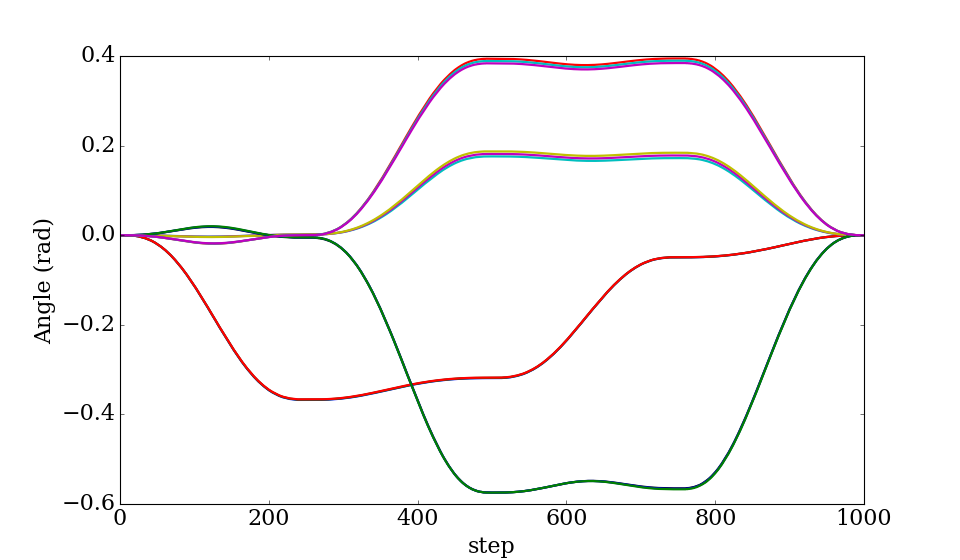

In [6]:

fig=plt.figure(figsize =(12,7))    
for i in (0,1,2,3):
    plt.plot(xy1[:,i]-xy1[0,i],linewidth=2.0)
    #plt.plot(xy2[:,i]-xy2[0,i],linewidth=2.0)
    plt.plot(xy3[:,i]-xy3[0,i],linewidth=2.0)    
    #plt.plot(xy4[:,i]-xy4[0,i],linewidth=2.0)
    plt.plot(xy5[:,i]-xy5[0,i],linewidth=2.0)
#     plt.plot(xy6[:,i])
#plt.title("Joint angles on five trajectories")
plt.ylabel("Angle (rad)")
plt.xlabel("step")
plt.show()

In [5]:
# [s0,s1,e1,w1

print "S0 p0"
print xy1[0,0] - xy2[0,0]
print xy2[0,0] - xy3[0,0]
print (xy1[0,0] - xy3[0,0])/2


print "S0 p400"
print xy1[400,0] - xy2[400,0]
print xy2[400,0] - xy3[400,0]
print (xy1[400,0] - xy3[400,0])/2

# print xy3[0,0] - xy4[0,0]
# print xy4[0,0] - xy5[0,0]

print "S1 p0"
print xy1[0,1] - xy2[0,1]
print xy2[0,1] - xy3[0,1]
print (xy1[0,1] - xy3[0,1])/2

print "S1 p400"
print xy1[400,1] - xy2[400,1]
print xy2[400,1] - xy3[400,1]
print (xy1[400,1] - xy3[400,1])/2

# print xy3[0,1] - xy4[0,1]
# print xy4[0,1] - xy5[0,1]

print "E1"
print xy1[0,2] - xy2[0,2]
print xy2[0,2] - xy3[0,2]
print (xy1[0,2] - xy3[0,2])/2

print "E1 p400"
print xy1[400,2] - xy2[400,2]
print xy2[400,2] - xy3[400,2]
print (xy1[400,2] - xy3[400,2])/2

# print xy3[0,2] - xy4[0,2]
# print xy4[0,2] - xy5[0,2]


print "W1"
print xy1[0,3] - xy2[0,3]
print xy2[0,3] - xy3[0,3]
print (xy1[0,3] - xy3[0,3])/2


print "W1 p400"
print xy1[400,3] - xy2[400,3]
print xy2[400,3] - xy3[400,3]
print (xy1[400,3] - xy3[400,3])/2
# print xy3[0,3] - xy4[0,3]
# print xy4[0,3] - xy5[0,3]



S0 p0
2.07424163818e-05
2.07424163818e-05
2.07424163818e-05
S0 p400
-2.02655792236e-06
-1.09672546387e-05
-6.49690628052e-06
S1 p0
0.00140446424484
0.00140458345413
0.00140452384949
S1 p400
0.00116527080536
0.00120013952255
0.00118270516396
E1
-0.000470876693726
-0.000468969345093
-0.000469923019409
E1 p400
-0.000456929206848
-0.000462174415588
-0.000459551811218
W1
-0.000673651695251
-0.000675827264786
-0.000674739480019
W1 p400
-0.00047892332077
-0.000481843948364
-0.000480383634567


In [10]:
S0: 0 S1: 0.0013 E1: -0.00046 W1: -0.00058

SyntaxError: invalid syntax (<ipython-input-10-ae2821d2d8dc>, line 1)

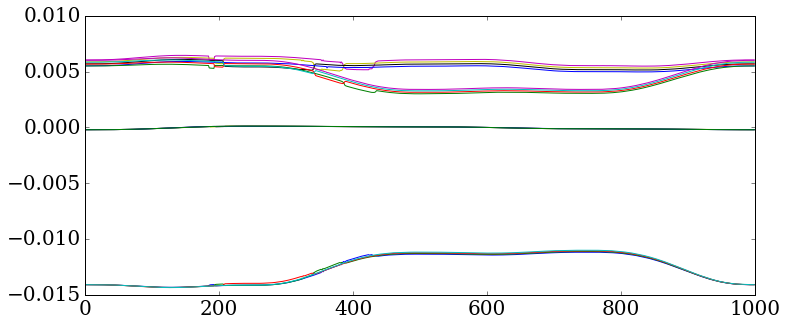

In [8]:
fig=plt.figure(figsize =(12,5))
plt.plot(xy2[:,1]-xy1[:,1])
plt.plot(xy3[:,1]-xy2[:,1])
plt.plot(xy4[:,1]-xy3[:,1])    
plt.plot(xy5[:,1]-xy4[:,1])    


plt.plot(xy2[:,2]-xy1[:,2])
plt.plot(xy3[:,2]-xy2[:,2])
plt.plot(xy4[:,2]-xy3[:,2])    
plt.plot(xy5[:,2]-xy4[:,2])    

plt.plot(xy2[:,3]-xy1[:,3])
plt.plot(xy3[:,3]-xy2[:,3])
plt.plot(xy4[:,3]-xy3[:,3])    
plt.plot(xy5[:,3]-xy4[:,3])   

plt.plot(xy2[:,0]-xy1[:,0])
plt.plot(xy3[:,0]-xy2[:,0])
plt.plot(xy4[:,0]-xy3[:,0])    
plt.plot(xy5[:,0]-xy4[:,0])   


plt.show()